In [ ]:
%%capture
!pip install kagglehub pandas matplotlib 'tensorflow[and-cuda]' supervision 

In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("gopalbhattrai/pascal-voc-2012-dataset")

print("Path to dataset files:", path)

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
# !ls /home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/JPEGImages

In [ ]:
# !cat /home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/ImageSets/Layout/train.txt
!ls /home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/Annotations/2007_000027.xml

In [ ]:
import xml.etree.ElementTree as ET

tree = ET.parse('/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/Annotations/2007_000027.xml')
root = tree.getroot()

for obj in root.findall('object'):
    cls = obj.find('name').text
    bndbox = obj.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    print(cls, xmin, ymin, xmax, ymax)

    # Optional: parse parts if needed
    for part in obj.findall('part'):
        part_name = part.find('name').text
        part_box = part.find('bndbox')
        pxmin = int(part_box.find('xmin').text)
        pymin = int(part_box.find('ymin').text)
        pxmax = int(part_box.find('xmax').text)
        pymax = int(part_box.find('ymax').text)
        print('   Part:', part_name, pxmin, pymin, pxmax, pymax)


In [ ]:
import supervision as sv
import cv2
import numpy as np

def infer(imagePath,coordinates = None):
    image = cv2.imread(imagePath)
    
    if coordinates == None:
        return image
    
    detections = sv.Detections(
        xyxy=np.array([coordinates]),
        class_id=np.array([0]),
        confidence=np.array([0.94])
    )
    
    # Create annotator using current API
    annotator = sv.BoxAnnotator()  # <- new name
    annotated_frame = annotator.annotate(scene=image.copy(), detections=detections)
    
    return annotated_frame

In [ ]:
# sv.plot_image(infer("/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/JPEGImages/2007_000027.jpg",coordinates= [174, 101, 349, 351]))

In [ ]:
id_to_label_map = {
    0: "background",1: "aeroplane",2: "bicycle",3: "bird",4: "boat",
    5: "bottle",6: "bus",7: "car",8: "cat",
    9: "chair",10: "cow",11: "diningtable",12: "dog",
    13: "horse",14: "motorbike",15: "person",16: "pottedplant",
    17: "sheep",18: "sofa",19: "train",20: "tvmonitor"
}
label_to_id_map = {v:k for k,v in id_to_label_map.items()}

In [ ]:
# def loss_function(y_true, y_pred, 
#                           lambda_obj=1.0, lambda_noobj=0.5, lambda_bbox=0.1, lambda_class=1.0):
    
#     # Split predictions and ground truth
#     obj_true = y_true[:, 0]  # objectness
#     bbox_true = y_true[:, 1:5]  # bounding box
#     class_true = y_true[:, 5:25]  # class probabilities
    
#     obj_pred = y_pred[:, 0]
#     bbox_pred = y_pred[:, 1:5]  
#     class_pred = y_pred[:, 5:25]
    
#     # Create masks
#     obj_mask = tf.cast(obj_true > 0.5, tf.float32)  # where objects exist
#     noobj_mask = tf.cast(obj_true <= 0.5, tf.float32)  # where no objects
    
#     # Objectness loss
#     obj_loss_pos = lambda_obj * obj_mask * tf.square(obj_true - obj_pred)
#     obj_loss_neg = lambda_noobj * noobj_mask * tf.square(obj_true - obj_pred)
#     obj_loss = tf.reduce_mean(obj_loss_pos + obj_loss_neg)
    
#     # Bounding box loss (only where objects exist)
#     bbox_loss = lambda_bbox * tf.reduce_mean(
#         obj_mask * tf.reduce_sum(tf.square(bbox_true - bbox_pred), axis=1)
#     )
    
#     # Classification loss (only where objects exist) 
#     class_loss = lambda_class * tf.reduce_mean(
#         obj_mask * tf.keras.losses.categorical_crossentropy(class_true, class_pred)
#     )
    
#     total_loss = obj_loss + bbox_loss + class_loss
#     return total_loss


In [ ]:
import tensorflow as tf
def loss_function(y_true, y_pred, 
                          lambda_obj=1.0, lambda_noobj=0.5, lambda_bbox=0.1, lambda_class=1.0):
    obj_true = y_true[:,0]
    bbox_true = y_true[:,1:5]
    class_true = y_true[:,5:]

    obj_pred = y_pred[:,0]
    bbox_pred = y_pred[:,1:5]
    class_pred = y_pred[:,5:]

    obj_mask = tf.expand_dims(tf.cast(obj_true > 0.5,dtype = tf.float32),axis  = 1)

    obj_loss = lambda_obj * tf.reduce_mean(tf.square((obj_true-obj_pred)))
    bbox_loss = lambda_bbox * tf.reduce_mean(tf.reduce_sum(tf.square(bbox_true-bbox_pred),axis = 1)*tf.squeeze(obj_mask))
    class_loss = lambda_class * tf.reduce_mean(tf.reduce_sum(tf.square(class_true-class_pred),axis = 1)*tf.squeeze(obj_mask))

    total_loss = obj_loss+bbox_loss+class_loss 
    
    return total_loss

# y_true = [
#     [1.0, 0.2, 0.3, 0.8, 0.9, 0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # has car
#     [0.0, 0.0, 0.0, 0.0, 0.0, 1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # no object  
#     [1.0, 0.1, 0.1, 0.6, 0.7, 0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]   # has person
# ]

# # Model Predictions (y_pred) 
# y_pred = [
#     [0.8, 0.25, 0.35, 0.75, 0.85, 0.1,0.1,0.7,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
#     [0.2, 0.1, 0.2, 0.3, 0.4,   0.8,0.1,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
#     [0.9, 0.12, 0.08, 0.58, 0.72, 0.1,0.8,0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
# ]
# loss_function(tf.constant(y_true), tf.constant(y_pred))

In [ ]:
with open('/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/ImageSets/Main/train.txt','r') as f:
    reader = f.read()
train_arr = reader.split('\n')
train_arr = [x for x in train_arr if x!='']

train_dataset = tf.data.Dataset.from_tensor_slices(train_arr)
with open('/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/ImageSets/Main/val.txt','r') as f:
    reader = f.read()
val_arr = reader.split('\n')
val_dataset = tf.data.Dataset.from_tensor_slices(val_arr)

In [ ]:
# train_arr = [x for x in train_arr if x!='']
train_arr

In [ ]:
import xml.etree.ElementTree as ET
def preprocess(image_id, img_dir, ann_dir):
    img_path = tf.strings.join([img_dir, "/", image_id, ".jpg"])
    xml_path = tf.strings.join([ann_dir, "/", image_id, ".xml"])

    def _xmlparser(xml_path_str):
        import xml.etree.ElementTree as ET
        xml_path_str = xml_path_str.numpy().decode()  # convert bytes to str
        tree = ET.parse(xml_path_str)
        root = tree.getroot()
        nameList, bndBoxList = [], []
        size = root.find('size')
        W = int(size.find('width').text)
        H = int(size.find('height').text)
        for x in root.findall('object'):
            name = x.find('name').text
            bndbox = x.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
        
            # normalize using W, H
            xmin /= W
            xmax /= W
            ymin /= H
            ymax /= H
        
            nameList.append(name)
            bndBoxList.append([xmin, ymin, xmax, ymax])
        # only take first object for simplicity
        one_hot_class = tf.one_hot(label_to_id_map[nameList[0]], depth=20)
        temp = tf.constant([1] + bndBoxList[0], dtype=tf.float32)
        y_label = tf.concat([temp, one_hot_class], axis=0)
        return y_label

    y_label = tf.py_function(func=_xmlparser, inp=[xml_path], Tout=tf.float32)
    y_label.set_shape([25])  # objectness + bbox + 20 classes

    # Load and preprocess image
    img_raw = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img = tf.image.resize_with_pad(img, 448, 448)
    img = tf.cast(img, tf.float32) / 255.0

    return img, y_label


In [ ]:
import xml.etree.ElementTree as ET
import numpy as np
import tensorflow as tf

tree = ET.parse('/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/Annotations/2007_000033.xml')
root = tree.getroot()

nameList = []
bndBoxList = []

# Get original image width and height
size = root.find('size')
W = int(size.find('width').text)
H = int(size.find('height').text)

# Extract objects + bounding boxes
for x in root.findall('object'):
    name = x.find('name').text
    bndbox = x.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    # normalize using W, H
    xmin /= W
    xmax /= W
    ymin /= H
    ymax /= H

    nameList.append(name)
    bndBoxList.append([xmin, ymin, xmax, ymax])

bndBoxList = np.array(bndBoxList, dtype=np.float32)
print("Normalized bounding boxes:\n", bndBoxList)

# Example: building label tensor for the first box
for x in range(len(nameList)):
    one_hot_class = tf.one_hot(label_to_id_map[nameList[x]], depth=20)
    temp = tf.constant([1] + bndBoxList[x].tolist(), dtype=tf.float32)  # [objectness, xmin, ymin, xmax, ymax]
    y_label = tf.concat([temp, one_hot_class], axis=0)
    print("Final label vector:", y_label.numpy())
    break


In [ ]:
img_dir = '/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/JPEGImages'
ann_dir = '/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/Annotations'
# for x in train_dataset.map(lambda x:preprocess(x,img_dir,ann_dir)).take(1):
#     print(x)

In [ ]:
# image_dataset = tf.raw_ops.LoadDataset(
#     path ="/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/JPEGImages",   
# )

In [54]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate

def TinyYOLO_Light(input_shape=(448, 448, 3), num_classes=20):
    """
    Simplest improvement: Remove global pooling, use spatial averaging
    """
    inputs = Input(shape=input_shape)
    
    # Backbone - same as original
    x = Conv2D(32, (3,3), strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Conv2D(64, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Conv2D(128, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Conv2D(256, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = MaxPooling2D((2,2))(x)
    
    x = Conv2D(512, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    x = MaxPooling2D((2,2))(x)
    
    # Detection head
    x = Conv2D(1024, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    
    x = Conv2D(1024, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.1)(x)
    
    # KEY CHANGE: Direct prediction layer instead of global pooling
    x = Conv2D(25, (3,3), padding='same')(x)  # Direct prediction
    
    # Average across spatial dimensions (preserve some spatial info in gradients)
    outputs = GlobalAveragePooling2D()(x) # Shape: (batch, 25)
    
    model = Model(inputs, outputs)
    return model


# Create model
model = TinyYOLO_Light()
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 448, 448, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 448, 448, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 448, 448, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 448, 448, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 224, 224, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_30 (LeakyReLU)      │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_31 (LeakyReLU)      │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_32 (LeakyReLU)      │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 14, 14, 1024)   │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,968,985 (60.92 MB)

 Trainable params: 15,962,905 (60.89 MB)

 Non-trainable params: 6,080 (23.75 KB)

In [49]:
def iou_metric(y_true, y_pred):
    """Calculate IoU metric for YOLO predictions"""
    # Extract objectness mask (only compute IoU where objects exist)
    obj_true = y_true[:, 0]
    obj_mask = tf.cast(obj_true > 0.5, tf.float32)
    
    # Extract bounding boxes
    bbox_true = y_true[:, 1:5]  # [xmin, ymin, xmax, ymax]
    bbox_pred = y_pred[:, 1:5]
    
    # Calculate intersection
    xmin_inter = tf.maximum(bbox_true[:, 0], bbox_pred[:, 0])
    ymin_inter = tf.maximum(bbox_true[:, 1], bbox_pred[:, 1])
    xmax_inter = tf.minimum(bbox_true[:, 2], bbox_pred[:, 2])
    ymax_inter = tf.minimum(bbox_true[:, 3], bbox_pred[:, 3])
    
    # Calculate intersection area
    inter_width = tf.maximum(0.0, xmax_inter - xmin_inter)
    inter_height = tf.maximum(0.0, ymax_inter - ymin_inter)
    intersection = inter_width * inter_height
    
    # Calculate union
    area_true = (bbox_true[:, 2] - bbox_true[:, 0]) * (bbox_true[:, 3] - bbox_true[:, 1])
    area_pred = (bbox_pred[:, 2] - bbox_pred[:, 0]) * (bbox_pred[:, 3] - bbox_pred[:, 1])
    union = area_true + area_pred - intersection
    
    # Calculate IoU
    iou = intersection / (union + 1e-7)  # Add small epsilon to avoid division by zero
    
    # Only compute IoU where objects exist
    masked_iou = iou * obj_mask
    
    # Return mean IoU only for samples with objects
    num_objects = tf.reduce_sum(obj_mask)
    mean_iou = tf.cond(
        num_objects > 0,
        lambda: tf.reduce_sum(masked_iou) / num_objects,
        lambda: 0.0
    )
    
    return mean_iou


In [ ]:
train_dataset_x = train_dataset.map(lambda x:preprocess(x,img_dir,ann_dir)).batch(10).prefetch(tf.data.AUTOTUNE)
model.compile(
    loss = loss_function,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics = [iou_metric]
)
model.fit(train_dataset_x , epochs = 10)

Epoch 1/10
  6/572 ━━━━━━━━━━━━━━━━━━━━ 1:08 121ms/step - iou_metric: 0.1171 - loss: 7.2474

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [ ]:
pred = model.predict(train_dataset_x.take(1))

In [ ]:
pred[0]
image = cv2.imread("/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val/JPEGImages/2008_000008.jpg")
detections = sv.Detections(
    xyxy=np.array([[pred[1][1]*500,pred[1][2]*486,pred[1][3]*500,pred[1][4]*486]]),
    class_id=np.array([0]),
    confidence=np.array([0.94])
)
for i in range(10): 
    print(np.argmax(pred[i][5:]))
# print(id_to_label[pred[2][]]
# Create annotator using current API
annotator = sv.BoxAnnotator()  # <- new name
annotated_frame = annotator.annotate(scene=image.copy(), detections=detections)
sv.plot_image(annotated_frame)


--- Image 1: 2008_000008.jpg ---
Objectness: 0.998
Predicted class: person (confidence: 0.204)
Normalized bbox: [0.300, 0.335, 0.754, 0.815]


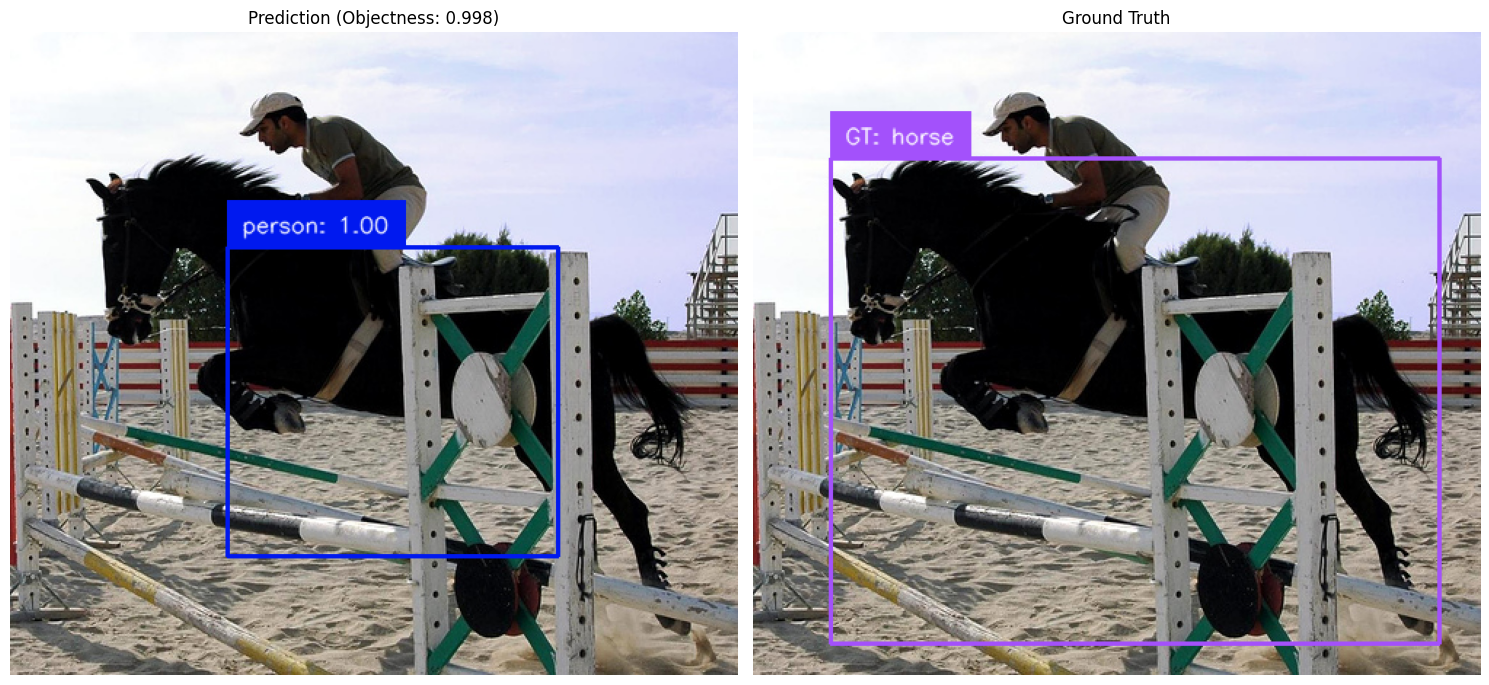


--- Image 2: 2007_000027.jpg ---
Objectness: 1.000
Predicted class: dog (confidence: 0.511)
Normalized bbox: [0.101, 0.052, 0.907, 0.963]


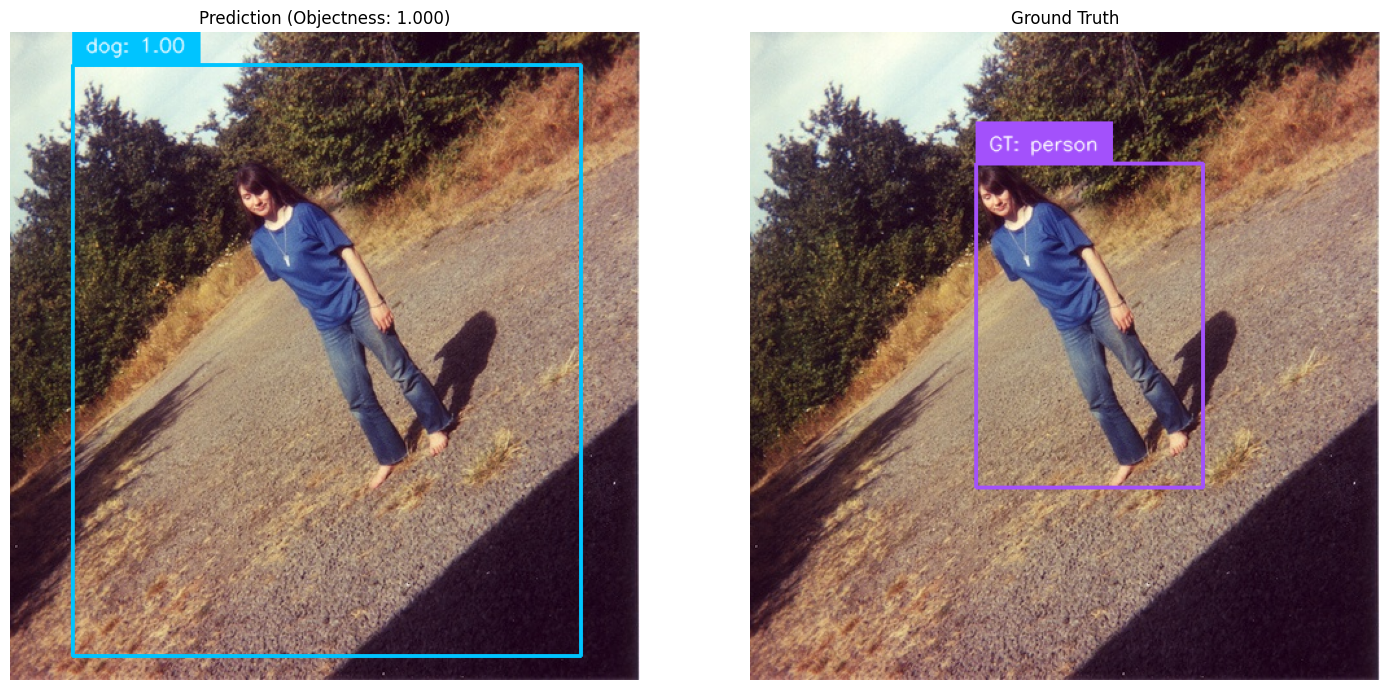


--- Image 3: 2007_000033.jpg ---
Objectness: 0.994
Predicted class: person (confidence: 0.157)
Normalized bbox: [0.284, 0.384, 0.745, 0.772]


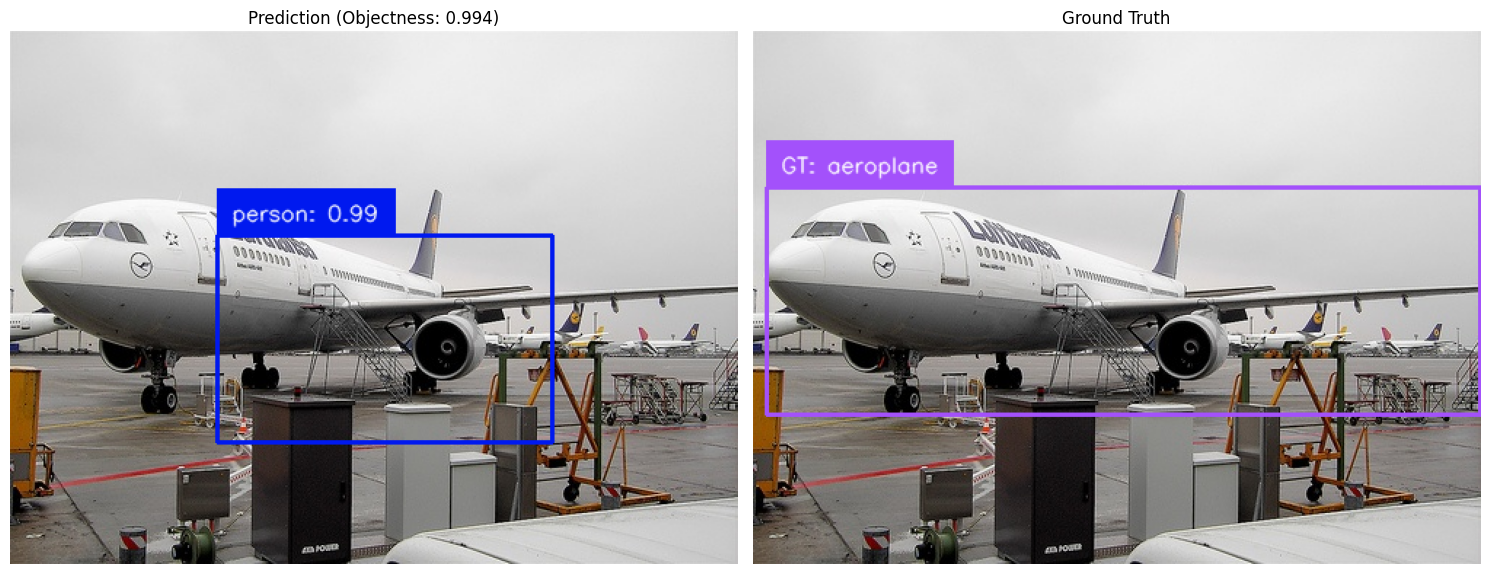

In [51]:
# Label mapping (from your notebook)
id_to_label_map = {
    0: "background", 1: "aeroplane", 2: "bicycle", 3: "bird", 4: "boat",
    5: "bottle", 6: "bus", 7: "car", 8: "cat",
    9: "chair", 10: "cow", 11: "diningtable", 12: "dog",
    13: "horse", 14: "motorbike", 15: "person", 16: "pottedplant",
    17: "sheep", 18: "sofa", 19: "train", 20: "tvmonitor"
}

def preprocess_image(image_path):
    """Preprocess a single image for inference"""
    img_raw = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    original_shape = tf.shape(img)[:2]  # H, W
    
    # Resize with padding (same as training)
    img = tf.image.resize_with_pad(img, 448, 448)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    
    return img, original_shape

def get_ground_truth_bbox(xml_path):
    """Extract ground truth bounding box from XML annotation"""
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Get image dimensions
    size = root.find('size')
    W = int(size.find('width').text)
    H = int(size.find('height').text)
    
    # Get first object (following your training approach)
    obj = root.find('object')
    if obj is not None:
        cls = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        return [xmin, ymin, xmax, ymax], cls, (W, H)
    return None, None, (W, H)

def denormalize_bbox(norm_bbox, original_shape):
    """Convert normalized bbox back to pixel coordinates"""
    H, W = original_shape[0], original_shape[1]
    xmin, ymin, xmax, ymax = norm_bbox
    
    # Denormalize
    xmin_pixel = int(xmin * W)
    ymin_pixel = int(ymin * H)
    xmax_pixel = int(xmax * W)
    ymax_pixel = int(ymax * H)
    
    return [xmin_pixel, ymin_pixel, xmax_pixel, ymax_pixel]

def inference_with_visualization(model, image_path, xml_path=None, confidence_threshold=0.5):
    """Run inference and visualize results"""
    
    # Preprocess image
    processed_img, original_shape = preprocess_image(image_path)
    
    # Run prediction
    prediction = model.predict(processed_img, verbose=0)[0]  # Get first (and only) prediction
    
    # Parse prediction
    objectness = prediction[0]
    bbox_norm = prediction[1:5]  # normalized coordinates
    class_probs = prediction[5:]
    predicted_class_id = np.argmax(class_probs)
    predicted_class_name = id_to_label_map[predicted_class_id]
    max_class_prob = np.max(class_probs)
    
    print(f"Objectness: {objectness:.3f}")
    print(f"Predicted class: {predicted_class_name} (confidence: {max_class_prob:.3f})")
    print(f"Normalized bbox: [{bbox_norm[0]:.3f}, {bbox_norm[1]:.3f}, {bbox_norm[2]:.3f}, {bbox_norm[3]:.3f}]")
    
    # Load original image
    original_img = cv2.imread(image_path)
    H, W = original_img.shape[:2]
    
    # Create visualization
    fig, axes = plt.subplots(1, 2 if xml_path else 1, figsize=(15, 7))
    if xml_path:
        axes = [axes[0], axes[1]] if hasattr(axes, '__len__') else [axes, None]
    else:
        axes = [axes]
    
    # Show prediction if confidence is above threshold
    if objectness > confidence_threshold:
        # Denormalize predicted bbox
        pred_bbox_pixel = denormalize_bbox(bbox_norm, (H, W))
        
        # Create detection for supervision
        detections = sv.Detections(
            xyxy=np.array([pred_bbox_pixel]),
            class_id=np.array([predicted_class_id]),
            confidence=np.array([objectness])
        )
        
        # Annotate image
        annotator = sv.BoxAnnotator()
        label_annotator = sv.LabelAnnotator()
        
        annotated_img = annotator.annotate(scene=original_img.copy(), detections=detections)
        labels = [f"{predicted_class_name}: {objectness:.2f}"]
        annotated_img = label_annotator.annotate(scene=annotated_img, detections=detections, labels=labels)
        
        # Convert BGR to RGB for matplotlib
        annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
        
        axes[0].imshow(annotated_img)
        axes[0].set_title(f'Prediction (Objectness: {objectness:.3f})')
        axes[0].axis('off')
    else:
        # Show original image without annotation
        original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        axes[0].imshow(original_img_rgb)
        axes[0].set_title(f'Prediction (Low confidence: {objectness:.3f})')
        axes[0].axis('off')
    
    # Show ground truth if XML is provided
    if xml_path and len(axes) > 1:
        gt_bbox, gt_class, _ = get_ground_truth_bbox(xml_path)
        if gt_bbox:
            # Create ground truth detection
            gt_detections = sv.Detections(
                xyxy=np.array([gt_bbox]),
                class_id=np.array([0]),  # Just for visualization
                confidence=np.array([1.0])
            )
            
            # Annotate ground truth
            gt_annotated = annotator.annotate(scene=original_img.copy(), detections=gt_detections)
            gt_labels = [f"GT: {gt_class}"]
            gt_annotated = label_annotator.annotate(scene=gt_annotated, detections=gt_detections, labels=gt_labels)
            
            # Convert BGR to RGB
            gt_annotated = cv2.cvtColor(gt_annotated, cv2.COLOR_BGR2RGB)
            
            axes[1].imshow(gt_annotated)
            axes[1].set_title('Ground Truth')
            axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'objectness': objectness,
        'bbox_normalized': bbox_norm,
        'bbox_pixel': denormalize_bbox(bbox_norm, (H, W)) if objectness > confidence_threshold else None,
        'predicted_class': predicted_class_name,
        'class_confidence': max_class_prob
    }

def batch_inference(model, image_paths, xml_paths=None, confidence_threshold=0.5):
    """Run inference on multiple images"""
    results = []
    
    for i, img_path in enumerate(image_paths):
        print(f"\n--- Image {i+1}: {img_path.split('/')[-1]} ---")
        xml_path = xml_paths[i] if xml_paths else None
        
        result = inference_with_visualization(
            model, img_path, xml_path, confidence_threshold
        )
        results.append(result)
    
    return results

def iou_metric(y_true, y_pred):
    """Calculate IoU metric for YOLO predictions"""
    # Extract objectness mask (only compute IoU where objects exist)
    obj_true = y_true[:, 0]
    obj_mask = tf.cast(obj_true > 0.5, tf.float32)
    
    # Extract bounding boxes
    bbox_true = y_true[:, 1:5]  # [xmin, ymin, xmax, ymax]
    bbox_pred = y_pred[:, 1:5]
    
    # Calculate intersection
    xmin_inter = tf.maximum(bbox_true[:, 0], bbox_pred[:, 0])
    ymin_inter = tf.maximum(bbox_true[:, 1], bbox_pred[:, 1])
    xmax_inter = tf.minimum(bbox_true[:, 2], bbox_pred[:, 2])
    ymax_inter = tf.minimum(bbox_true[:, 3], bbox_pred[:, 3])
    
    # Calculate intersection area
    inter_width = tf.maximum(0.0, xmax_inter - xmin_inter)
    inter_height = tf.maximum(0.0, ymax_inter - ymin_inter)
    intersection = inter_width * inter_height
    
    # Calculate union
    area_true = (bbox_true[:, 2] - bbox_true[:, 0]) * (bbox_true[:, 3] - bbox_true[:, 1])
    area_pred = (bbox_pred[:, 2] - bbox_pred[:, 0]) * (bbox_pred[:, 3] - bbox_pred[:, 1])
    union = area_true + area_pred - intersection
    
    # Calculate IoU
    iou = intersection / (union + 1e-7)  # Add small epsilon to avoid division by zero
    
    # Only compute IoU where objects exist
    masked_iou = iou * obj_mask
    
    # Return mean IoU only for samples with objects
    num_objects = tf.reduce_sum(obj_mask)
    mean_iou = tf.cond(
        num_objects > 0,
        lambda: tf.reduce_sum(masked_iou) / num_objects,
        lambda: 0.0
    )
    
    return mean_iou

def classification_accuracy_metric(y_true, y_pred):
    """Calculate classification accuracy only where objects exist"""
    # Extract objectness mask
    obj_true = y_true[:, 0]
    obj_mask = tf.cast(obj_true > 0.5, tf.float32)
    
    # Extract class predictions
    class_true = y_true[:, 5:]
    class_pred = y_pred[:, 5:]
    
    # Get predicted class indices
    true_classes = tf.argmax(class_true, axis=1)
    pred_classes = tf.argmax(class_pred, axis=1)
    
    # Check if classifications are correct
    correct_predictions = tf.cast(tf.equal(true_classes, pred_classes), tf.float32)
    
    # Only compute accuracy where objects exist
    masked_correct = correct_predictions * obj_mask
    
    # Return mean accuracy only for samples with objects
    num_objects = tf.reduce_sum(obj_mask)
    class_accuracy = tf.cond(
        num_objects > 0,
        lambda: tf.reduce_sum(masked_correct) / num_objects,
        lambda: 0.0
    )
    
    return class_accuracy

def objectness_accuracy_metric(y_true, y_pred):
    """Calculate objectness prediction accuracy"""
    obj_true = y_true[:, 0]
    obj_pred = y_pred[:, 0]
    
    # Convert to binary predictions (threshold at 0.5)
    obj_true_binary = tf.cast(obj_true > 0.5, tf.float32)
    obj_pred_binary = tf.cast(obj_pred > 0.5, tf.float32)
    
    # Calculate accuracy
    correct_obj = tf.cast(tf.equal(obj_true_binary, obj_pred_binary), tf.float32)
    return tf.reduce_mean(correct_obj)

# Example usage:
if __name__ == "__main__":
    # Updated model compilation with meaningful metrics:
    """
    model.compile(
        loss=loss_function,
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=[iou_metric, classification_accuracy_metric, objectness_accuracy_metric]
    )
    """
    
    # Example paths (update these to your actual paths)
    base_path = "/home/garvthakral/.cache/kagglehub/datasets/gopalbhattrai/pascal-voc-2012-dataset/versions/1/VOC2012_train_val/VOC2012_train_val"
    
    # Single image inference
    img_path = f"{base_path}/JPEGImages/2008_000008.jpg"
    xml_path = f"{base_path}/Annotations/2008_000008.xml"
    
    # Uncomment when you have a trained model:
    # result = inference_with_visualization(model, img_path, xml_path)
    # print("Final result:", result)
    
    # Batch inference example
    image_paths = [
        f"{base_path}/JPEGImages/2008_000008.jpg",
        f"{base_path}/JPEGImages/2007_000027.jpg",
        f"{base_path}/JPEGImages/2007_000033.jpg"
    ]
    xml_paths = [
        f"{base_path}/Annotations/2008_000008.xml",
        f"{base_path}/Annotations/2007_000027.xml", 
        f"{base_path}/Annotations/2007_000033.xml"
    ]
    
    # Uncomment when you have a trained model:
    # batch_results = batch_inference(model, image_paths, xml_paths)
    # Uncomment when you have a trained model:
    batch_results = batch_inference(model, image_paths, xml_paths)